Connected to thermal (Python 3.11.5)

In [1]:
# -*- coding: utf-8 -*-
# Go back to root directory of project.
%cd ../

/home/gramos/Projects/MIIA-A23/code/mercury-duckling


In [2]:
import numpy as np

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import matplotlib.pyplot as plt
from rich.progress import track

In [3]:
def show_mask(
        mask, ax,
        color=np.array([30/255, 144/255, 255/255, 0.6]),
        random_color=False
    ):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1], 
        color='green', 
        marker='o', 
        s=marker_size, 
        edgecolor='black', 
        linewidth=1.25,
        alpha=1
    )
    ax.scatter(
        neg_points[:, 0], 
        neg_points[:, 1], 
        color='red', 
        marker='X',
        s=marker_size, 
        edgecolor='black', 
        linewidth=1.25,
        alpha=1
    )   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def NOCS(ious, thresh, max_clicks=20):
    ''' Number of clicks to reach threshold'''
    nocs = []
    for i in range(ious.shape[0]):
        for j in range(max_clicks):
            if(ious[i, j] >= thresh):
                nocs.append(j + 1)
                break
        if(len(nocs) == i):
            nocs.append(max_clicks)
    return nocs

iou_score = lambda y_hat, y : np.logical_and(y_hat, y).sum() / np.logical_or(y_hat, y).sum()

def test_pipeline(pipeline):
    ious = []
    for i in track(range(5), description="Testing"):
        image, target, id = pipeline._dataset[i]
        image = (image*255).astype(np.uint8)
        target = target.transpose(2, 0, 1)
        for i, mask in enumerate(np.array(target)):
            mask_ious = [.0]
            aux = None
            masks = None
            for prompts in pipeline.sampler.interact(mask):
                masks, aux = pipeline.predict(
                    image, prompts, aux if aux is not None else masks, id
                )
                pipeline.sampler.set_outputs(masks)
                mask_ious.append(iou_score(masks, mask))
            ious.append(mask_ious)
    return ious

masks_color = np.array([30/225, 225/225, 100/225, 0.6])
root = "../../data/_500_per_folder/merged_dataset_delam/"

# Pipeline: SAM 

In [ ]:
from mercury_duckling.configs import SAM_THERMAL
from mercury_duckling.pipelines.sam_interactive import SamInteractiveTest

In [4]:
SAM_THERMAL["dataset"]["root"] = root
pipeline = SamInteractiveTest(SAM_THERMAL)
pipeline.on_experiment_start(pipeline)

sam_ious = test_pipeline(pipeline)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Pipeline: RITM

In [4]:
import sys

sys.path.append("./mercury_duckling/models/")

from mercury_duckling.configs import RITM_THERMAL
from mercury_duckling.pipelines.ritm_interactive import RitmInteractiveTest

In [5]:
RITM_THERMAL["dataset"]["root"] = root
pipeline = RitmInteractiveTest(RITM_THERMAL)
pipeline.on_experiment_start(pipeline)

ritm_ious = test_pipeline(pipeline)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Pipeline: Unet

In [4]:
import sys
sys.path.append("./mercury_duckling/models/inter_unet")

from mercury_duckling.configs import UNET_THERMAL
from mercury_duckling.pipelines.unet_interactive import UnetInteractiveTest

In [5]:
UNET_THERMAL["dataset"]["root"] = root
pipeline = UnetInteractiveTest(UNET_THERMAL)
pipeline.on_experiment_start(pipeline)

unet_ious = test_pipeline(pipeline)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
modifying input layer


Output()

# Results

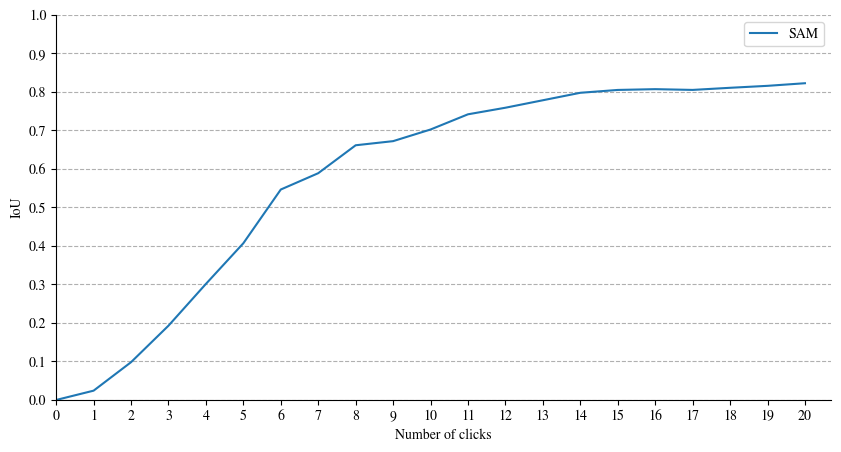

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
for ious in [sam_ious, ritm_ious, unet_ious]:
    ious = np.array(ious)
    means = ious.mean(axis=0)
    ax.plot(means)
ax.set_xlabel("Number of clicks")
ax.set_ylabel("IoU")
ax.set_xticks(range(21))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim([0, 1])
ax.set_xlim([0, 20.7])
ax.spines[['right', 'top']].set_visible(False)
plt.legend(["SAM", "RITM", "UNet"])
plt.grid(axis='y', linestyle='--')
plt.show()